In [12]:
"""
eleanor_comparison.ipynb

Author: Ryne Dingler

Code to take quaver hybrid regression light curves and compare to eleanor pipeline 
Flux is normalized by scaling 1/np.nanmedian(flux) s.t. lc oscillates about ~1
Eleanor process may take a while, especially for multiple sectors, so be patient.

"""


from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

import astropy
import eleanor
import numpy as np
import pandas as pd
import os
import sys
from pathlib import Path
from astropy import units as u
import matplotlib
import matplotlib.pyplot as plt
import lightkurve as lk
from astropy.coordinates import SkyCoord
from astropy.coordinates import get_icrs_coordinates


In [13]:
def eleanor_comp(subdir,file,target, FITS, savedir, aperture):
    
    
    '''
    Function which executes the download of light curves, TESScut download
    eleanor regression, and comparison plots.
    
    inputs:
        subdir (string) 
            - automatically obtained directory name where quaver regression is located
        file (string)  
            - automatically obtained file name of quaver data
        target (string)  
            - automatically obtained name of object of interest
        FITS (boolean)  
            - determines if a .fits file of TESScut is downloaded and saved
        savedir (string)  
            - directory name where .fits files will be saved if FITS = True
    '''

    
    ## Open light curve data and set to dataframe for float parsing
    data = open(os.path.join(subdir, file), "r")
#     print(os.path.join(subdir, file))
    df = pd.read_table(os.path.join(subdir, file), sep = ' ', header=None, dtype='float')
    

    sector_data = lk.search_tesscut(target)
    # Presents the available TESScuts which can be obtained
    print(sector_data)
    
    
    ###########################################################################################################################################
    
    ## Determine if multiple sectors are observed
    ## If you wish to skip sectors, do not use 'all' or 'cycle#'
    ## you must tell the program how many sectors you want out of 
    ## the total and then enter each sector individually
    multisec = input('Multiple sectors observed (Y/N) ?')
            
    if multisec == 'Y' or multisec == 'y' or multisec == 'YES' or multisec == 'yes':
        
        
        print("Enter desired number of sectors. Then enter secter values one at a time.")
        print("If full cycle of observations, enter 'cycle#' #:[1,2,3,4] with no spaces.")
        
        sect = []
        target_data = []

        sectors = input('How many sectors? ')

        if sectors == 'cycle1':
            sect = [1,2,3,4,5,6,7,8,9,10,11,12,13]
        elif sectors == 'cycle2':
            sect = [14,15,16,17,18,19,20,21,22,23,24,25,26]
        elif sectors == 'cycle3':
            sect = [27,28,29,30,31,32,33,34,35,36,37,38,39]
        elif sectors == 'cycle4':
            sect = [40,41,42,43,44,45,46,47,48,49,50,51,52]
        elif sectors == 'all':
            sect = 'all'    
        else:
            sectors = int(sectors)
            for i in range(0,sectors):
                sect.append(int(input('Sector Number: ')))
            # print(sect)
        
        coord = get_icrs_coordinates(target)                
        try:
            qso = eleanor.multi_sectors(coords = coord, tc=True, sectors = sect)
        except:
            qso = eleanor.multi_sectors(coords = coord, sectors = sect)

        tmp_sect = int(sect[0])
        directory = savedir+target
        
        for x in qso:
            datum = eleanor.TargetData(x, height=27, width=27, save_postcard = True,  regressors='corner') #bkg_size=51, do_psf=True, do_pca=True,
            target_data.append(datum)
            
            if FITS == True:
                try:
                    os.mkdir('../QSO_FITS/'+target)
                    print("Directory ../QSO_FITS/'%s' created\n" %target)
                    datum.save(directory+'/'+target+'_eleanor_flux_sector%i.fits'%tmp_sect)
                except FileExistsError:
                    print("Saving to folder ../QSO_FITS/'%s'\n" %target)
                    datum.save(directory+'/'+target+'_eleanor_flux_sector%i.fits'%tmp_sect)
            tmp_sect+=1
        
        ## Determine if eleanor aperture selection shall be saved
        if aperture == True:
            for sector, datum in enumerate(target_data):

                fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,6))
                plt.suptitle('eleanor aperture selection for '+target+' sector %i'%sector)
                pix = ax1.imshow(datum.tpf[0])
                fig.colorbar(pix, ax=ax1)
                ax1.set_title('Target Pixel File')
                aper = ax2.imshow(datum.aperture)
                fig.colorbar(aper,ax=ax2, location='right')
                ax2.set_title('Aperture')

                plt.savefig(subdir+'/'+target+'_eleanor_aperture_sector%i.pdf'%sect[sector], format = 'pdf')
                plt.close()

        fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(9,6))
        ax1.errorbar(df[0], df[1], df[2], marker='o', markersize=1, color='b', linestyle='none', label="quaver")
    
        for sector, datum in enumerate(target_data):
            
            q = datum.quality == 0

            ax2.errorbar(datum.time[q], datum.raw_flux[q], datum.flux_err[q], marker='o', markersize=1, color= 'k', label="raw", alpha=0.8)
            ax2.errorbar(datum.time[q], datum.corr_flux[q], datum.flux_err[q], marker='o', markersize=1, color= 'r', label="corrected", alpha=0.8)
    
    
    ###########################################################################################################################################
    
    ## If Multiple sectors are not observed
    
    else:

        sect = int(input('Sector Number: '))
        coord = get_icrs_coordinates(target)
        
        qso = eleanor.Source(coords = coord, tc=True, sector = sect)
        target_data = eleanor.TargetData(qso, height=27, width=27, save_postcard = True, regressors='corner')
        directory = savedir+target

        if FITS == True:
            try:
                os.mkdir('../QSO_FITS/'+target)
                print("Directory ../QSO_FITS/'%s' created\n" %target)
                target_data.save(directory+'/'+target+'_eleanor_flux_sector%i.fits'%sect)
            except FileExistsError:
                print("Saving to folder ../QSO_FITS/'%s'\n" %target)
                target_data.save(directory+'/'+target+'_eleanor_flux_sector%i.fits'%sect)

        ## Determine if eleanor aperture selection shall be saved
        if aperture == True:
            fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))
            plt.suptitle('eleanor aperture selection for '+target+' sector %i'%sect)
            pix = ax1.imshow(target_data.tpf[0])
            fig.colorbar(pix, ax=ax1)
            ax1.set_title('Target Pixel File')
            aper = ax2.imshow(target_data.aperture)
            fig.colorbar(aper,ax=ax2, location='right')
            ax2.set_title('Aperture')

            plt.savefig(subdir+'/'+target+'_eleanor_aperture_sector%i.pdf'%sect, format = 'pdf')
            plt.close()
        
        fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(9,6))
        ax1.errorbar(df[0], df[1], df[2], marker='o', markersize=1, color='b', linestyle='none', label="quaver")
        
        q = target_data.quality == 0

        ax2.errorbar(target_data.time[q], target_data.raw_flux[q], target_data.flux_err[q], marker='o', markersize=1, color= 'k', label="raw", alpha=0.8)
        ax2.errorbar(target_data.time[q], target_data.corr_flux[q], target_data.flux_err[q], marker='o', markersize=1, color= 'r', label="corrected", alpha=0.8)
   
    fig.supylabel('Flux [e$^{-}$ s$^{-1}$]')
    plt.xlabel('Time [BJD - 2457000]')
    fig.suptitle(target+': light curve comparison')
    ax1.set_title("quaver")
    ax2.set_title("eleanor")
    ax2.legend(['raw','corrected'])
    fig.tight_layout()
    plt.savefig(subdir+'/'+target+'_eleanor_flux.pdf', format = 'pdf')
    plt.show()
    plt.close()

    
    return()
    



Desired target name (all to do entire folder):  all


SearchResult containing 3 data products.

 #     mission     year  author exptime      target_name       distance
                                   s                            arcsec 
--- -------------- ---- ------- ------- ---------------------- --------
  0 TESS Sector 10 2019 TESScut    1426 2MASXJ12571157-1724344      0.0
  1 TESS Sector 37 2021 TESScut     475 2MASXJ12571157-1724344      0.0
  2 TESS Sector 46 2021 TESScut     475 2MASXJ12571157-1724344      0.0


Multiple sectors observed (Y/N) ? n
Sector Number:  10


Saving to folder ../QSO_FITS/'2MASXJ12571157-1724344'



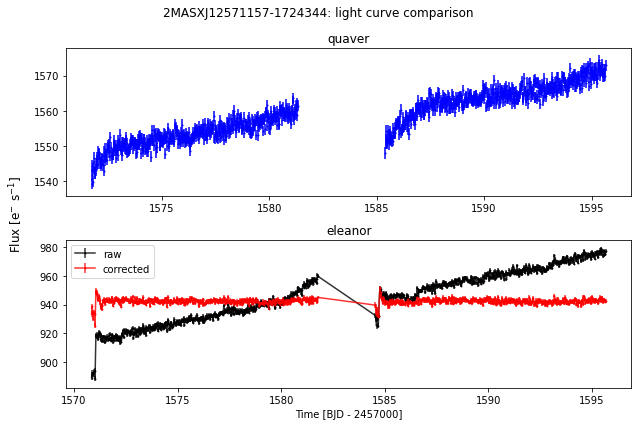

SearchResult containing 2 data products.

 #     mission     year  author exptime target_name distance
                                   s                 arcsec 
--- -------------- ---- ------- ------- ----------- --------
  0 TESS Sector 05 2018 TESScut    1426       3C120      0.0
  1 TESS Sector 32 2020 TESScut     475       3C120      0.0


KeyboardInterrupt: Interrupted by user

In [14]:
"""
Program to make comparison plots of eleanor and quaver regressions.
Due to differnces in scale/normalization the plots are made side by side 
where only the final quaver regressed light curve is plotted in a panel 
above a panel containing both the raw and regressed eleanor light curves.
If FITS is true, a copy of the FITS file for sectors' light curves will 
be saved to the provided save directory.

parameters:
    rootdir (string) 
        - directory name which will be looped through to identify quaver
            regressed objects and locate quaver regressed light curves
    FITS (boolean)  
        - determines if a .fits file of TESScut is downloaded and saved
    savedir (string)  
        - directory name where .fits files will be saved if FITS = True
    target_name (string)
        - name of target for which user desires to make a comparison for
            eleanor and quaver regressions. Target name must match exactly
            as used when performing quaver regression to properly find and
            identify the data. User can use 'all' as the target name if the
            desire to search through and do this for every object in a
            specified directory
"""


rootdir = '/users/rdingler/AGNstudy/LightCurves/Analysis/'

FITS = True

aperture = True

savedir = '/users/rdingler/AGNstudy/QSO_FITS/'

target_name = input('Desired target name (all to do entire folder): ') 

if target_name == 'all' or target_name == 'All' or target_name == 'ALL':
    
    for subdir, dirs, files in os.walk(rootdir):

        target = os.path.basename(subdir)
 
        for file in files:
            
            if file.endswith('_cycle1_hybrid_lc.dat'):

                eleanor_comp(subdir,file,target,FITS,savedir,aperture)

else:
    for subdir, dirs, files in os.walk(rootdir):

        target = os.path.basename(subdir)
        if target == target_name:

            for file in files:
                
                if file.endswith('_cycle1_hybrid_lc.dat'):
                    eleanor_comp(subdir,file,target,FITS,savedir,aperture)
                    
                    # sys.exit()
         
         